# A Monument to All Your Data

Business Case: Halo is legendary franchise in the entertainment world. First introduced with the original Xbox in 2001, the Halo universe has widely expanded into other mediums and spinoff games, yet the pillars of the Halo brand remain the blockbuster action shooter games starring the one and only Sierra-117. Following the debut of Halo Infinite gameplay at the recent Xbox showcase on July 23, 2020, twitter was abuzz about the new game and had a lot of opinions. 

The goal of this project is to build a sentiment model that can accurately predict the reception of Halo Infinite from a sample of tweets between July 22 and July 29, 2020. 

## About the Data

There are two data sources used for this project:

1. A kaggle Dataset with 1.6 million evaluated tweets.

https://www.kaggle.com/kazanova/sentiment140

2. Custom scraped tweets (using Twint) containing 8000+ tweets about Halo between July 22-29, 2020.





## Process

1. Import and handle data
2. Preprocess text data

In [ ]:
As usual the first step is to load in the necessary packages into the workbook

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# EXPORT
KERAS_MODEL = 'model.h5'
WORD2VEC_MODEL = 'model.w2v'
TOKENIZER_MODEL = 'tokenizer.pkl'
ENCODER_MODEL = 'encoder.pkl'

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/ellis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding= 'ISO-8859-1', names = ['target', 
                                                                                                  'ids', 
                                                                                                  'date', 
                                                                                                  'flag', 
                                                                                                  'user', 
                                                                                                  'text'])

In [93]:
df.head(5)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
target    1600000 non-null int64
ids       1600000 non-null int64
date      1600000 non-null object
flag      1600000 non-null object
user      1600000 non-null object
text      1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [34]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [94]:
df['target'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [8]:
df.drop(index=0, inplace= True)

In [40]:
decode_map = {0: 'NEGATIVE',2: 'NEUTRAL' 4: 'POSITIVE'}
def decode_sentiment(label):
    return decode_map[int(label)]

In [41]:
%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [42]:
df.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Distribution of Sentiment')

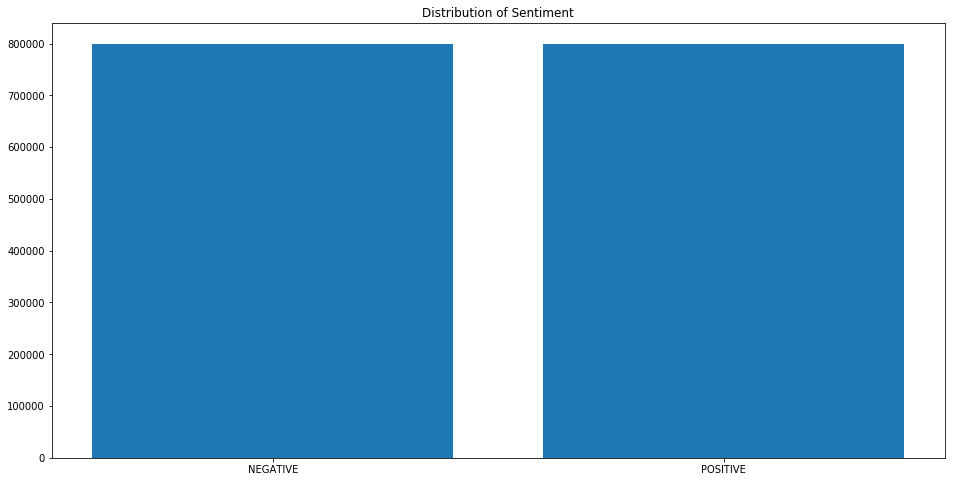

In [95]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title('Distribution of Sentiment')

## Preprocess the dataset

In [45]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [46]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [47]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 35.6 s, sys: 75.1 ms, total: 35.7 s
Wall time: 35.7 s


## Train/Test Split

In [48]:
df_train, df_test = train_test_split(df, test_size= 0.2, random_state=42)
print('Train Size:', len(df_train))
print('Test Size:', len(df_test))

TRAIN size: 1280000
TEST size: 320000


## Tokenize


In [70]:
%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs
Total words 290419


In [71]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

CPU times: user 18.1 s, sys: 453 ms, total: 18.6 s
Wall time: 18.6 s


### Word2Vec

Word2vec is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus. While Word2vec is not a deep neural network, it turns text into a numerical form that deep neural networks can understand.

In [97]:
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.27 s, sys: 174 ms, total: 2.44 s
Wall time: 2.44 s


In [ ]:
gensim.models.word2vec.Word2Vec()

In [50]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=16)

In [51]:
w2v_model.build_vocab(documents)

2020-07-28 15:17:48,496 : INFO : collecting all words and their counts
2020-07-28 15:17:48,497 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-28 15:17:48,516 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-07-28 15:17:48,534 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-07-28 15:17:48,556 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-07-28 15:17:48,578 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-07-28 15:17:48,599 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-07-28 15:17:48,621 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-07-28 15:17:48,646 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-07-28 15:17:48,669 : INFO : PROGRESS: at s

2020-07-28 15:17:50,276 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-07-28 15:17:50,302 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-07-28 15:17:50,328 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-07-28 15:17:50,354 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-07-28 15:17:50,381 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-07-28 15:17:50,406 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-07-28 15:17:50,430 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-07-28 15:17:50,453 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-07-28 15:17:50,475 : INFO : PROGRESS: at sentence #800000, processed 577088

In [106]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print('Vocabulary Size', vocab_size)

Vocabulary Size 30369


In [53]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

2020-07-28 15:17:56,580 : INFO : training model with 16 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-07-28 15:17:57,602 : INFO : EPOCH 1 - PROGRESS: at 18.11% examples, 1476110 words/s, in_qsize 31, out_qsize 0
2020-07-28 15:17:58,613 : INFO : EPOCH 1 - PROGRESS: at 35.86% examples, 1460369 words/s, in_qsize 28, out_qsize 3
2020-07-28 15:17:59,619 : INFO : EPOCH 1 - PROGRESS: at 55.75% examples, 1516361 words/s, in_qsize 32, out_qsize 0
2020-07-28 15:18:00,629 : INFO : EPOCH 1 - PROGRESS: at 75.35% examples, 1536617 words/s, in_qsize 30, out_qsize 1
2020-07-28 15:18:01,637 : INFO : EPOCH 1 - PROGRESS: at 95.77% examples, 1561347 words/s, in_qsize 30, out_qsize 1
2020-07-28 15:18:01,774 : INFO : worker thread finished; awaiting finish of 15 more threads
2020-07-28 15:18:01,776 : INFO : worker thread finished; awaiting finish of 14 more threads
2020-07-28 15:18:01,788 : INFO : worker thread finished; awaiting finish of 13 more thread

2020-07-28 15:18:18,076 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-07-28 15:18:18,078 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-28 15:18:18,079 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-28 15:18:18,082 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-28 15:18:18,082 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-28 15:18:18,083 : INFO : EPOCH - 4 : training on 9227204 raw words (8222154 effective words) took 5.5s, 1488376 effective words/s
2020-07-28 15:18:19,101 : INFO : EPOCH 5 - PROGRESS: at 18.65% examples, 1526157 words/s, in_qsize 31, out_qsize 0
2020-07-28 15:18:20,109 : INFO : EPOCH 5 - PROGRESS: at 37.05% examples, 1514278 words/s, in_qsize 31, out_qsize 0
2020-07-28 15:18:21,113 : INFO : EPOCH 5 - PROGRESS: at 54.78% examples, 1494875 words/s, in_qsize 31, out_qsize 0
2020-07-28 15:18:22,120 : INFO : EPOCH 5 - PROGRESS: at 74.15%

2020-07-28 15:18:39,692 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-07-28 15:18:39,693 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-07-28 15:18:39,694 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-28 15:18:39,695 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-28 15:18:39,696 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-28 15:18:39,710 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-07-28 15:18:39,713 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-28 15:18:39,715 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-28 15:18:39,716 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-28 15:18:39,717 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-28 15:18:39,717 : INFO : EPOCH - 8 : training on 9227204 raw words (8222924 effect

2020-07-28 15:19:01,949 : INFO : worker thread finished; awaiting finish of 14 more threads
2020-07-28 15:19:01,961 : INFO : worker thread finished; awaiting finish of 13 more threads
2020-07-28 15:19:01,965 : INFO : worker thread finished; awaiting finish of 12 more threads
2020-07-28 15:19:01,966 : INFO : worker thread finished; awaiting finish of 11 more threads
2020-07-28 15:19:01,967 : INFO : worker thread finished; awaiting finish of 10 more threads
2020-07-28 15:19:01,968 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-07-28 15:19:01,969 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-07-28 15:19:01,970 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-28 15:19:01,970 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-28 15:19:01,971 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-28 15:19:01,978 : INFO : worker thread finished; awaiting finish of 4 more th

2020-07-28 15:19:22,477 : INFO : EPOCH 16 - PROGRESS: at 75.89% examples, 1543790 words/s, in_qsize 30, out_qsize 1
2020-07-28 15:19:23,478 : INFO : EPOCH 16 - PROGRESS: at 89.45% examples, 1458011 words/s, in_qsize 31, out_qsize 0
2020-07-28 15:19:24,084 : INFO : worker thread finished; awaiting finish of 15 more threads
2020-07-28 15:19:24,096 : INFO : worker thread finished; awaiting finish of 14 more threads
2020-07-28 15:19:24,100 : INFO : worker thread finished; awaiting finish of 13 more threads
2020-07-28 15:19:24,123 : INFO : worker thread finished; awaiting finish of 12 more threads
2020-07-28 15:19:24,127 : INFO : worker thread finished; awaiting finish of 11 more threads
2020-07-28 15:19:24,131 : INFO : worker thread finished; awaiting finish of 10 more threads
2020-07-28 15:19:24,132 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-07-28 15:19:24,133 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-07-28 15:19:24,134 : INFO : w

2020-07-28 15:19:41,928 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-28 15:19:41,929 : INFO : EPOCH - 19 : training on 9227204 raw words (8222693 effective words) took 5.6s, 1464507 effective words/s
2020-07-28 15:19:42,947 : INFO : EPOCH 20 - PROGRESS: at 16.38% examples, 1338731 words/s, in_qsize 31, out_qsize 0
2020-07-28 15:19:43,948 : INFO : EPOCH 20 - PROGRESS: at 34.56% examples, 1416510 words/s, in_qsize 31, out_qsize 0
2020-07-28 15:19:44,952 : INFO : EPOCH 20 - PROGRESS: at 53.05% examples, 1450052 words/s, in_qsize 31, out_qsize 0
2020-07-28 15:19:45,962 : INFO : EPOCH 20 - PROGRESS: at 73.19% examples, 1498261 words/s, in_qsize 31, out_qsize 0
2020-07-28 15:19:46,971 : INFO : EPOCH 20 - PROGRESS: at 93.15% examples, 1523533 words/s, in_qsize 32, out_qsize 1
2020-07-28 15:19:47,212 : INFO : worker thread finished; awaiting finish of 15 more threads
2020-07-28 15:19:47,227 : INFO : worker thread finished; awaiting finish of 14 more threads
2020-0

2020-07-28 15:20:03,513 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-28 15:20:03,514 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-07-28 15:20:03,516 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-28 15:20:03,518 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-28 15:20:03,519 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-28 15:20:03,520 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-28 15:20:03,521 : INFO : EPOCH - 23 : training on 9227204 raw words (8222129 effective words) took 5.4s, 1511767 effective words/s
2020-07-28 15:20:04,543 : INFO : EPOCH 24 - PROGRESS: at 17.24% examples, 1405355 words/s, in_qsize 30, out_qsize 1
2020-07-28 15:20:05,545 : INFO : EPOCH 24 - PROGRESS: at 34.67% examples, 1418232 words/s, in_qsize 29, out_qsize 2
2020-07-28 15:20:06,575 : INFO : EPOCH 24 - PROGRESS: at 53.70% examples, 1453771 w

2020-07-28 15:20:25,304 : INFO : worker thread finished; awaiting finish of 10 more threads
2020-07-28 15:20:25,306 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-07-28 15:20:25,307 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-07-28 15:20:25,307 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-28 15:20:25,308 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-28 15:20:25,309 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-28 15:20:25,318 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-07-28 15:20:25,320 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-28 15:20:25,325 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-28 15:20:25,326 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-28 15:20:25,328 : INFO : worker thread finished; awaiting finish of 0 more thread

2020-07-28 15:20:46,736 : INFO : worker thread finished; awaiting finish of 15 more threads
2020-07-28 15:20:46,739 : INFO : worker thread finished; awaiting finish of 14 more threads
2020-07-28 15:20:46,749 : INFO : worker thread finished; awaiting finish of 13 more threads
2020-07-28 15:20:46,763 : INFO : worker thread finished; awaiting finish of 12 more threads
2020-07-28 15:20:46,767 : INFO : worker thread finished; awaiting finish of 11 more threads
2020-07-28 15:20:46,769 : INFO : worker thread finished; awaiting finish of 10 more threads
2020-07-28 15:20:46,770 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-07-28 15:20:46,771 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-07-28 15:20:46,772 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-28 15:20:46,774 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-28 15:20:46,778 : INFO : worker thread finished; awaiting finish of 5 more t

CPU times: user 13min 33s, sys: 3.91 s, total: 13min 37s
Wall time: 2min 55s


(263132581, 295270528)

In [150]:
w2v_model.most_similar('halo')

/Users/ellis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('fallout', 0.5006712675094604),
 ('odst', 0.47402986884117126),
 ('playstation', 0.44195127487182617),
 ('diablo', 0.41696423292160034),
 ('bioshock', 0.40825143456459045),
 ('l4d2', 0.3995174765586853),
 ('starcraft', 0.3836352229118347),
 ('3oh', 0.3791135549545288),
 ('rockband', 0.3720516562461853),
 ('sims', 0.36959683895111084)]

In [215]:
w2v_model.most_similar('livestream')

/Users/ellis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('broadcast', 0.40872207283973694),
 ('streaming', 0.4063020348548889),
 ('ign', 0.405301958322525),
 ('cnn', 0.40511471033096313),
 ('iplayer', 0.4040786921977997),
 ('preciso', 0.39394378662109375),
 ('picnik', 0.3910572826862335),
 ('stream', 0.38495999574661255),
 ('espn', 0.37402355670928955),
 ('gremlins', 0.3705165982246399)]

## Label Encoder

In [72]:
labels = df_train.target.unique().tolist()
labels

['POSITIVE', 'NEGATIVE']

In [73]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


## Baseline Model

In [204]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
dummy = DummyClassifier(strategy='stratified').fit(x_train, y_train)
dummy_pred = dummy.predict(x_test)

In [205]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\
import seaborn as sns
import matplotlib.pyplot as graph
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from IPython.display import display

graph.style.use('fivethirtyeight')

In [206]:
def judge_model(model, name, plot=False):
    print(name)
    print('-'*20)
    
    print('Training Performance')
    print('-> Acc:', accuracy_score(y_train, model.predict(x_train)) )
    print('-> AUC:', roc_auc_score(y_train, model.predict_proba(x_train)[:, 1] ))
    
    print('Testing Performance')
    print('-> Acc:', accuracy_score(y_train, model.predict(x_train)) )
    print('-> AUC:', roc_auc_score(y_test, model.predict_proba(x_test)[:, 1] ))
    print()
    
    if plot:
        fpr, tpr, thres = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
        graph.figure(figsize=(4, 4))
        graph.plot(fpr, tpr, label='Test')
        graph.xlabel('FPR')
        graph.ylabel('TPR')
        graph.show()

DummyClassifier(strategy='stratified')
--------------------
Training Performance
-> Acc: 0.50017265625
-> AUC: 0.49949309000540226
Testing Performance
-> Acc: 0.50045078125
-> AUC: 0.5005059388100996



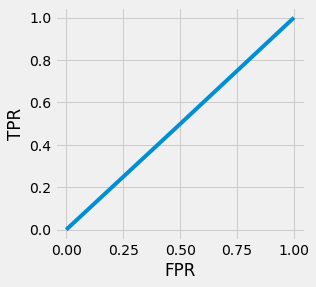

In [208]:
judge_model(dummy, dummy, plot=True)

## Embedding Layer

In [74]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [76]:
embedding_layer = Embedding(vocab_size, 
                            300, 
                            weights=[embedding_matrix], 
                            input_length=300, 
                            trainable=False)

In [77]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [78]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [79]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [80]:
%%time
history = model.fit(x_train, y_train,
                    batch_size= 1024,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.7511WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-28 16:27:54,035 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3291s 3s/step - loss: 0.5031 - accuracy: 0.7511 - val_loss: 0.4671 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.7681WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-28 17:22:40,324 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3283s 3s/step - loss: 0.4778 - accuracy: 0.7681 - val_loss: 0.4569 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.7726WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-28 18:17:25,530 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3282s 3s/step - loss: 0.4712 - accuracy: 0.7726 - val_loss: 0.4529 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.7747WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-28 19:12:00,199 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3272s 3s/step - loss: 0.4674 - accuracy: 0.7747 - val_loss: 0.4488 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4647 - accuracy: 0.7763WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-28 20:07:22,463 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3319s 3s/step - loss: 0.4647 - accuracy: 0.7763 - val_loss: 0.4507 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.7772WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-28 21:02:09,607 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3284s 3s/step - loss: 0.4635 - accuracy: 0.7772 - val_loss: 0.4486 - val_accuracy: 0.7899 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.7779WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-28 21:56:45,745 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3273s 3s/step - loss: 0.4620 - accuracy: 0.7779 - val_loss: 0.4463 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4610 - accuracy: 0.7787WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-28 22:51:25,898 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3277s 3s/step - loss: 0.4610 - accuracy: 0.7787 - val_loss: 0.4464 - val_accuracy: 0.7913 - lr: 0.0010
CPU times: user 2d 13min 32s, sys: 1d 13h 28min 41s, total: 3d 13h 42min 14s
Wall time: 7h 18min 29s


In [81]:
%%time
score = model.evaluate(x_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 215s 686ms/step - loss: 0.4455 - accuracy: 0.7912

ACCURACY: 0.7911843657493591
LOSS: 0.4454956650733948
CPU times: user 19min 26s, sys: 14min 45s, total: 34min 12s
Wall time: 3min 35s


In [82]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-07-28 22:56:48,355 : INFO : saving Word2Vec object under model.w2v, separately None
2020-07-28 22:56:48,360 : INFO : not storing attribute vectors_norm
2020-07-28 22:56:48,360 : INFO : not storing attribute cum_table
2020-07-28 22:56:49,479 : INFO : saved model.w2v


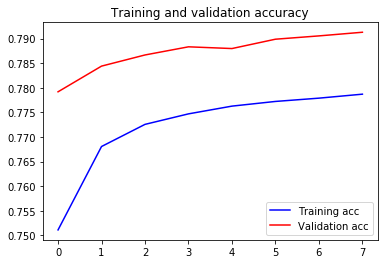

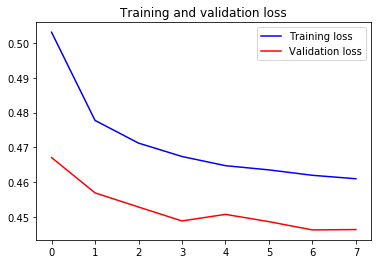

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [92]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)


In [91]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [85]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [160]:
def pred(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return label 

In [147]:
predict('halo')

{'label': 'POSITIVE',
 'score': 0.7038811445236206,
 'elapsed_time': 0.05259275436401367}

In [87]:
predict('Halo Infinite looks awesome')

{'label': 'POSITIVE',
 'score': 0.9751156568527222,
 'elapsed_time': 0.049160003662109375}

In [103]:
predict('Halo 5 was the worst iteration of the franchise')

{'label': 'NEGATIVE',
 'score': 0.02658303827047348,
 'elapsed_time': 0.055711984634399414}

In [170]:
predict('hell no')

{'label': 'NEGATIVE',
 'score': 0.367274671792984,
 'elapsed_time': 0.049696922302246094}

In [209]:
predict('hell yes')

{'label': 'POSITIVE',
 'score': 0.8316201567649841,
 'elapsed_time': 0.061515092849731445}

In [117]:
predict('I am a monument to all your sins')

{'label': 'NEUTRAL',
 'score': 0.6382704973220825,
 'elapsed_time': 0.055806875228881836}

In [137]:
predict('set a fire in your heart spartan')

{'label': 'POSITIVE',
 'score': 0.8019468784332275,
 'elapsed_time': 0.05218791961669922}

In [172]:
from tqdm import tqdm

In [156]:
halo_tweets = pd.read_csv('halo_tweets_processed')

In [171]:
halo_tweets.drop_duplicates(subset=['text'], inplace = True)

In [173]:
halo_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8653 entries, 0 to 12448
Data columns (total 6 columns):
Unnamed: 0    8653 non-null int64
id            8653 non-null int64
username      8653 non-null object
text          8653 non-null object
date          8653 non-null object
predict       8653 non-null object
dtypes: int64(2), object(4)
memory usage: 473.2+ KB


In [174]:
from tqdm import tqdm
tqdm.pandas()
halo_tweets['predict'] = halo_tweets.text.progress_apply(lambda x: pred(x))

/Users/ellis/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 8653/8653 [06:03<00:00, 23.82it/s]


In [178]:
halo_tweets.columns

Index(['Unnamed: 0', 'id', 'username', 'text', 'date', 'predict'], dtype='object')

In [181]:
halo_tweets.drop(['Unnamed: 0'], axis=1, inplace=True)

In [182]:
halo_tweets.head()

,id,username,text,date,predict
0,1288528587910512640,stu_fx,phase 2 pewpew halo vfx blender pic twitter co...,2020-07-29 13:35:29 EDT,POSITIVE
1,1288527953513545729,shovel_spades,chief wait arbiter us megaconstrux halo pic tw...,2020-07-29 13:32:58 EDT,POSITIVE
2,1288526847114764289,sutrosidetalk,episode 56 applepodcasts go xboxgamesshowcase ...,2020-07-29 13:28:34 EDT,POSITIVE
3,1288526695847399424,notamuggle11,get halo infinite ok graphics texture problems...,2020-07-29 13:27:58 EDT,NEUTRAL
4,1288526522781970433,ryno_666,noticed lot similarities previous helmets past...,2020-07-29 13:27:17 EDT,POSITIVE


In [183]:
halo_tweets.to_csv('predictions.csv')

Text(0.5, 1.0, 'Distribution of Sentiment')

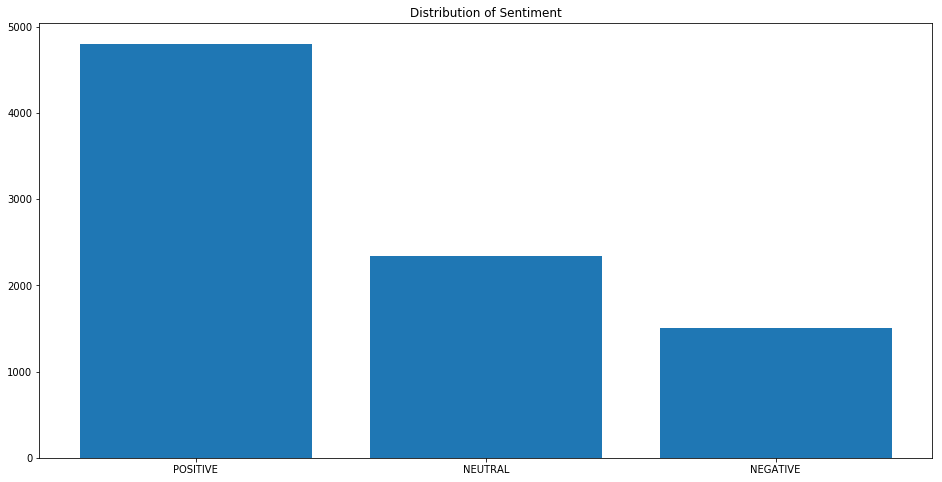

In [184]:
target_cnt = Counter(halo_tweets.predict)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title('Distribution of Sentiment')

In [185]:
halo_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8653 entries, 0 to 12448
Data columns (total 5 columns):
id          8653 non-null int64
username    8653 non-null object
text        8653 non-null object
date        8653 non-null object
predict     8653 non-null object
dtypes: int64(1), object(4)
memory usage: 725.6+ KB


In [187]:
pd.set_option('display.max_colwidth', -1)

In [188]:
halo_tweets.head(50)

,id,username,text,date,predict
0,1288528587910512640,stu_fx,phase 2 pewpew halo vfx blender pic twitter com tznbulx9ty,2020-07-29 13:35:29 EDT,POSITIVE
1,1288527953513545729,shovel_spades,chief wait arbiter us megaconstrux halo pic twitter com vf0lbu62vk,2020-07-29 13:32:58 EDT,POSITIVE
2,1288526847114764289,sutrosidetalk,episode 56 applepodcasts go xboxgamesshowcase joined orandomingue podcastevolved haloinfinite halo xbox xboxseriesx fable destiny2 crossfirex hellblade2 stalker2 themedium avowed,2020-07-29 13:28:34 EDT,POSITIVE
3,1288526695847399424,notamuggle11,get halo infinite ok graphics texture problems next gen still looks great gone back roots answer 4k realistic graphics days epic game good simple answer graphics make game,2020-07-29 13:27:58 EDT,NEUTRAL
4,1288526522781970433,ryno_666,noticed lot similarities previous helmets past new multiplayer halo infinite armor looks like quite bit reach influence design halo pic twitter com gsilbo0awc,2020-07-29 13:27:17 EDT,POSITIVE
5,1288526256720543746,itsgingerbilly,3 followers away goal supportsmallstreamers twitch streamersconnected live twitchtv free gaming twitch gaming gamer twitchstreamer streamer twitchtv videogames pc halo,2020-07-29 13:26:13 EDT,POSITIVE
6,1288526108120567810,justin_mcgill,fans critics share discontent haloinfinite graphics got responses 343 microsoft responses try hide fact halo infinite doa watch video xbox xboxseriesx gamingnews gaming doa pic twitter com mxjfcnrkc1,2020-07-29 13:25:38 EDT,NEUTRAL
7,1288525934241480706,nethilez,neth take new forge mode ridiculously powerful halo infinite via youtube halo haloinfinite haloinfiniteforge praisecraig craigthebrute bbb pic twitter com k42yesopkz,2020-07-29 13:24:57 EDT,POSITIVE
8,1288525424574828544,fannttv,way sorry loud screaming twitch halo gfuel pic twitter com 1vhb9rpwpb,2020-07-29 13:22:55 EDT,NEUTRAL
9,1288525263324749825,sxdaniel99,gareth coker sets fire heart halo infinite halo official site haloinfinite games bso halo music,2020-07-29 13:22:17 EDT,POSITIVE


In [189]:
negative_df = halo_tweets['predict']== 'NEGATIVE'

In [190]:
negative_df.head(50)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    True 
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    True 
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    True 
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
Name: predict, dtype: bool

In [191]:
halo_tweets_negative = halo_tweets[negative_df]

In [192]:
halo_tweets_negative.head(50)

,id,username,text,date,predict
15,1288520005508902912,xademu2,brutes throwing suicide grunts like haloinfinite halo pic twitter com sxrc5mnznr,2020-07-29 13:01:23 EDT,NEGATIVE
28,1288552197324787712,lucckyduck,would love see gameplay xbsx halo show power lets go let rip boys time xboxseriesx xbox haloinfinite xboxonex fable forza perfectdark halo firedup aarongreenberg xboxp3 pic twitter com yfxw0urocf,2020-07-29 15:09:18 EDT,NEGATIVE
40,1288547431085420547,l0rdshacks,dead space 0 fun sfm sfm deadspace halo halospotlight pic twitter com 8ffcpgtx6l,2020-07-29 14:50:22 EDT,NEGATIVE
55,1288539510578413568,cernersandals,biggest issues w mcc pc adding friends absolute nightmare really needs simplified report feature baked game toxic players get away alt tabbing fullscreen mode murders everything halo masterchief mcc,2020-07-29 14:18:53 EDT,NEGATIVE
100,1288538638561624064,swirlykalen,halo forge slow without magnets halo4 ruined forge,2020-07-29 14:15:25 EDT,NEGATIVE
104,1288535284179664896,snapshothcs,halo never fails halo halo5 halo5guardians haloinfinite xbox xboxseriesx stream twitch youtube esports 343industries hcs pic twitter com axuvsnrlah,2020-07-29 14:02:06 EDT,NEGATIVE
141,1288517211422957569,thelizardkiller,new video far cry 7 halo infinite halo halo masterchief xbox,2020-07-29 12:50:17 EDT,NEGATIVE
146,1288514581263011845,aleishatipton,still time left vote tonight twitch stream halo theouterworlds currently tied,2020-07-29 12:39:50 EDT,NEGATIVE
149,1288511796425494529,roninstrife,phil xboxp3 workers abused 343i hope part management arent problem mentioning letter wrote tears halo haloinfinite xbox xboxseriesx xboxgamesshowcase pic twitter com yvmyweehcz,2020-07-29 12:28:46 EDT,NEGATIVE
152,1288510257216409600,darkcloud25,xboxseriesx xbox fanboys question coming sony games naughty dog u defend halo completely ignore stuff going 343studios also said 23rds event u would speak energy never,2020-07-29 12:22:39 EDT,NEGATIVE


In [194]:
sample_1 = halo_tweets.sample(50, random_state=42)

In [196]:
sample_1.to_csv('sample1.csv')

In [200]:
sample_2 = halo_tweets.sample(50, random_state=101)

In [201]:
sample_2.to_csv('sample2.csv')

In [195]:
negative_sample = halo_tweets_negative.sample(50, random_state=13)

In [198]:
negative_sample.to_csv('negative_sample.csv')

In [199]:
negative_sample.head(50)

,id,username,text,date,predict
9663,1286430598274244609,ubertimmeh,felt bit disappointed reveal haloinfinite sure halo combat looked solid visually lacklustre idea master chief grapple,2020-07-23 18:38:50 EDT,NEGATIVE
12243,1286360199964565505,demodoesntcare,people really claiming haloinfinite ruined grappling hooks probably tamest addition 343 add staying faithful original trilogy pic twitter com 6dezwellrm,2020-07-23 13:59:05 EDT,NEGATIVE
8969,1285960457585655809,xbox_batsamm,rumours hellblade ii fable reboot everwild importantly halo infinite gameplay hoping see xboxgamesshowcase haloinfinite xboxone halo pic twitter com mvsu3iedwe,2020-07-22 11:30:39 EDT,NEGATIVE
1655,1287521919315501057,singlrdy2mingle,noble squad halomcc haloreach halomasterchiefcollection halo halomccpc reach videogamephotography photography nvidia xbox microsoft 343industries bungie ansel nvidiaansel,2020-07-26 18:55:21 EDT,NEGATIVE
104,1288535284179664896,snapshothcs,halo never fails halo halo5 halo5guardians haloinfinite xbox xboxseriesx stream twitch youtube esports 343industries hcs pic twitter com axuvsnrlah,2020-07-29 14:02:06 EDT,NEGATIVE
8264,1286237335521091585,far_no1,sorry fam halo stream issues pc check dreamsps4 runs mean time,2020-07-23 05:50:52 EDT,NEGATIVE
6499,1286444983898107904,grandnoble,omg misses headshot shoots brutes shoulders armor breaks piece piece based directly shots halo halo haloinfinite unyshek ske7ch tashi343i latenighthalo hiddenxperia halofollowercom pic twitter com gwbmxz9ptr,2020-07-23 19:35:59 EDT,NEGATIVE
1890,1287377405296939008,jgravityy,grind real blood sweat tears halo pic twitter com nbpeoabfdn,2020-07-26 09:21:06 EDT,NEGATIVE
11581,1286372015050563584,soulstereo81,saw good stuff xboxgamesshowcase today haloinfinite armor looks dope destiny2beyondlight fable wanted see avowed wanted see crossfirex aware campaign warhammer40kdarktide wanted see themedium looks,2020-07-23 14:46:02 EDT,NEGATIVE
11087,1286384098739658753,gamerblinkhylt,haloinfinite looks bad bro gameplay wise brute look xbox series x,2020-07-23 15:34:03 EDT,NEGATIVE


In [202]:
sample_1.head()

,id,username,text,date,predict
8906,1285978808747687936,gamsterworld,ready haloinfinite halo halo6thanniversary xboxgamesshowcase xboxseriesx xbox xboxone subscribe sub4sub shooter action adventure pic twitter com qnldfayhil,2020-07-22 12:43:34 EDT,POSITIVE
10558,1286399490958786568,dunn1216,one thought location saw haloinfinite demo kind looked like made forge lmao,2020-07-23 16:35:13 EDT,NEUTRAL
9990,1286418625973428224,jrose962,looking simp mistreat onlyfans haloinfinite free trial today stupid click link,2020-07-23 17:51:15 EDT,NEGATIVE
10836,1286390796569255942,dbfig,today uploaded 3 videos xboxseriesx showcase please share leave feedback mean lot haloinfinite reaction fable reaction xboxgamesshowcase review breakdown,2020-07-23 16:00:40 EDT,NEUTRAL
7994,1286319964882755584,coachmayyne,still relevant today halo haloinfinite pic twitter com xghbzmdjlo,2020-07-23 11:19:12 EDT,NEUTRAL


# Bonus Round

In [210]:
#!pip install vaderSentiment

     |████████████████████████████████| 133kB 5.0MB/s eta 0:00:01


In [211]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [212]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [214]:
sentiment_analyzer_scores('get halo infinite ok graphics texture problems next gen still looks great gone back roots answer 4k realistic graphics days epic game good simple answer graphics make game	')

get halo infinite ok graphics texture problems next gen still looks great gone back roots answer 4k realistic graphics days epic game good simple answer graphics make game	 {'neg': 0.075, 'neu': 0.669, 'pos': 0.256, 'compound': 0.7579}
